# Sentiment Analysis & Classification Evaluation:

## 1. Project Setup:

### 1.1 Import Libraries:

In [29]:
%pip install twython

Note: you may need to restart the kernel to use updated packages.


In [30]:
%pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [31]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import optuna

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import gensim
from gensim.models import Word2Vec

from sklearn.decomposition import PCA

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

from bs4 import BeautifulSoup
import re

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [32]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = Tokenizer()

In [33]:
! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

### 1.2 Load the Data:

In [34]:
data_path = '/kaggle/input/twitter-tweets-sentiment-dataset/Tweets.csv'

In [35]:
data = pd.read_csv(data_path)

In [36]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


None

In [37]:
data.loc[:, 'text'] = data['text'].apply(lambda text: str(text))

In [38]:
data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


## 2. EDA:

### 2.1 Explore the target variable:

In [39]:
data['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [40]:
data['sentiment'].value_counts()

sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64

In [41]:
data['sentiment'].value_counts()*100/data.shape[0]

sentiment
neutral     40.457043
positive    31.228849
negative    28.314108
Name: count, dtype: float64

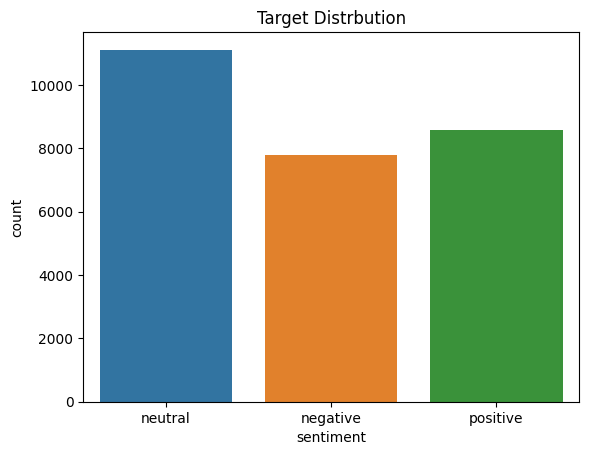

In [42]:
sns.countplot(data = data, x='sentiment')
plt.title('Target Distrbution')
plt.show()

1. As described in the data card, target variable contains of 3 labels (negative, neutral, positive).
2. The labels isn't well balanced but It's okay there isn't very big difference.

### 2.2 Explore the Distrbution of tweets length:

In [43]:
data['text_length'] = data['text'].apply(lambda text: len(str(text)))

In [44]:
data['text_length'].describe()

count    27481.000000
mean        68.327645
std         35.605403
min          3.000000
25%         39.000000
50%         64.000000
75%         97.000000
max        141.000000
Name: text_length, dtype: float64

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


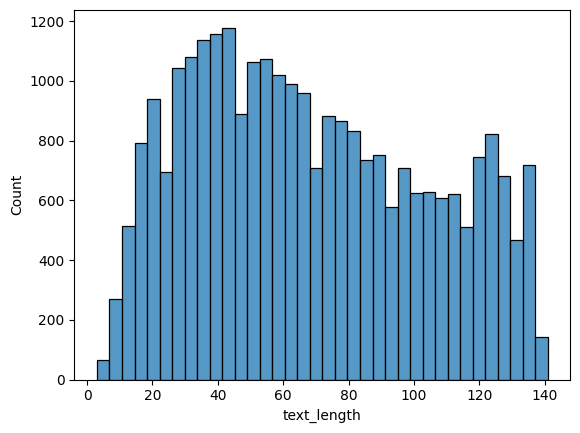

In [45]:
sns.histplot(data['text_length'])
plt.show('Distrbution of letters\'s number of tweets')
plt.show()

1. We have tweets with only 2 characters, It's too short.
2. the maximum tweets size is 140 characters, and that's okay because the max allowed number of characters on twitter was 140.

## 3. Data Preprocessing:

### 3.1 Text Cleaning:

#### 3.1.1 Extract emojis :)

In [46]:
# Define common emoticons
EMOTICON_PATTERN = re.compile(r"""
    (\s|^)          # Start with space or beginning of string
    ([:;xX=]-?[)D(pP\/(])  # Typical emoticons with optional nose (-)
    (\s|$)          # End with space or end of string
""", re.VERBOSE)

In [47]:
def extract_emoticons(text):
    return [match[1] for match in EMOTICON_PATTERN.findall(text)]

In [48]:
i = 0
for tweet in data['text']:
    extracted_emojis = extract_emoticons(str(tweet))
    if len(extracted_emojis) > 0:
        print(f"Tweet: {tweet} -> Emoticons: {extract_emoticons(tweet)}")
        i += 1
    if i == 9:
        break # to show only first 10 tweets with emojis

Tweet:  as much as i love to be hopeful, i reckon the chances are minimal =P i`m never gonna get my cake and stuff -> Emoticons: ['=P']
Tweet: Trying to decide on a movie with the friends.. not going to well! lol :p  No bible study 2nite, which means ****-day cake  buy my own?? -> Emoticons: [':p']
Tweet:  Si, no bueno  I guess I just don`t entertain him :/ -> Emoticons: [':/']
Tweet:  ...i`m sorry about you are still sick  u know most of them, AND i know that u will guess the 'pelzer present' ;-) -> Emoticons: [';-)']
Tweet:  Aww, congrats to the family. ;) Send me piccies in the email! -> Emoticons: [';)']
Tweet: Happy Star Wars Day ...  'May the 4th be with you'.... read http://tinyurl.com/axsujx for more ;) -> Emoticons: [';)']
Tweet:  awww she`s laavly ;) I had to come in  but I`ve got a stunning wee tan (l) ;) yourself? -> Emoticons: [';)', ';)']
Tweet:  awww  I`ll let you off - but you`d better be there for my next 30th! XD -> Emoticons: ['XD']
Tweet: Safari 4 beta (OS X) is in 

In [49]:
all_emojis = []
for tweet in data['text']:
    extracted_emojis = extract_emoticons(str(tweet))
    if len(extracted_emojis) > 0:
        all_emojis += extracted_emojis
print(all_emojis)

['=P', ':p', ':/', ';-)', ';)', ';)', ';)', ';)', 'XD', 'X)', ':p', '=D', '=D', ';-)', ';)', ':-/', ';-)', 'xD', ':/', '=/', ':p', ';)', 'xD', ':/', 'XD', ';)', 'XD', ';)', ';)', ';P', ';D', ';)', ':-D', ';D', ';)', ':/', ';)', 'xD', ';)', ':-P', ';-)', ';)', '=D', '=P', ';)', ':p', ';D', '=/', ';D', ';)', ';)', ';)', 'xD', ';)', ':p', ';)', ':-/', ';)', ';-)', ';)', ';)', 'xD', ';)', 'xD', 'XD', 'xD', '=(', '=D', '=P', ';)', ':/', ';)', ';)', ';)', ':p', 'xD', ':p', ';)', ';)', ':/', ':p', 'XD', '=D', ';)', ':-D', ':/', ':-p', ':-D', ';)', ';)', ';D', ';)', ';)', ';D', ';)', ';)', ';)', ';)', ':/', ';)', ';)', 'XD', ';)', ';)', ':p', ':p', ':/', ';-)', ';)', ';-)', ':/', ';(', ';)', 'xD', ':/', ';)', 'xD', ':p', ';)', ':-p', '=D', ';-)', ':/', ':/', ':-/', 'XD', 'X)', ':p', ':/', '=D', ';(', ';)', ':p', ';)', ';)', ';)', ';-)', '=/', 'XP', 'xD', ';)', '=D', ':p', 'xD', ';)', ';)', ':-p', ';)', ';)', ';)', ';-)', ';D', '=/', ':-p', 'XD', 'XD', 'x)', ';P', ':p', ';)', ';)', ':/', 'xD', 

In [50]:
all_emojis = set(all_emojis)
print(all_emojis)

{'=/', ':p', 'XP', ':-p', 'x)', '=(', ';(', ';)', ':-D', '=D', ';p', ';-)', 'xD', ';P', ';D', 'XD', '=p', ':-/', 'X)', '=P', ':/', ':-P'}


#### 3.1.2 Replace emojis with text :) -> happy_face

In [51]:
EMOTICON_MAP = {
    ":)": "happyface",
    ":-)": "happyface",

    ":-D": "bigsmile",
    ":D": "bigsmile",
    "=D": "bigsmile",
    "=-D": "bigsmile",

    "xD": "laughingface",
    "XD": "laughingface",
    

    ":-P": "tongueoutface",
    ":-p": "tongueoutface",
    ":p": "tongueoutface",
    ":P": "tongueoutface",
    "=-P": "tongueoutface",
    "=-p": "tongueoutface",
    "=P": "tongueoutface",
    "=p": "tongueoutface",
    
    
    ":-/": "uncertainface",
    ":/": "uncertainface",
    "=-/": "uncertainface",
    "=/": "uncertainface",
    
    "X)": "grinningface",
    "x)": "grinningface",
    "X-)": "grinningface",
    "x-)": "grinningface",

    "XP": "playfultongueface",
    "xP": "playfultongueface",
    "X-P": "playfultongueface",
    "x-P": "playfultongueface",
    
    ";p": "winkingtongueoutface",
    ";P": "winkingtongueface",
        
    ";-)": "winkingface",
    ";)": "winkingface",
    
    
        
    ";D": "bigwinksmile",
    ";-D": "bigwinksmile",
    
    ";(": "sadwinkingface",
    ";-(": "sadwinkingface",
    
    ":-(": "sadface",
    "=-(": "sadface",
    ":(": "sadface",
    "=(": "sadface",
}

In [52]:
def replace_emoticons(text):
    def replace_match(match):
        emoticon = match.group(2)  # Extract only the emoticon part
        return match.group(1) + EMOTICON_MAP.get(emoticon, emoticon) + match.group(3)  # Preserve spacing

    return EMOTICON_PATTERN.sub(replace_match, str(text))

In [53]:
replace_emoticons('http:// test XD this ;) function')

'http:// test laughingface this winkingface function'

In [54]:
data['cleaned_text'] = data['text'].apply(replace_emoticons)

In [55]:
data.loc[:10,'cleaned_text'].values

array([' I`d have responded, if I were going',
       ' Sooo SAD I will miss you here in San Diego!!!',
       'my boss is bullying me...', ' what interview! leave me alone',
       ' Sons of ****, why couldn`t they put them on the releases we already bought',
       'http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth',
       '2am feedings for the baby are fun when he is all smiles and coos',
       'Soooo high', ' Both of you',
       ' Journey!? Wow... u just became cooler.  hehe... (is that possible!?)',
       ' as much as i love to be hopeful, i reckon the chances are minimal tongueoutface i`m never gonna get my cake and stuff'],
      dtype=object)

#### 3.1.3 Lowering the characters:

In [56]:
data['cleaned_text'] = data['cleaned_text'].str.lower()

In [57]:
data.loc[:10,'cleaned_text'].values

array([' i`d have responded, if i were going',
       ' sooo sad i will miss you here in san diego!!!',
       'my boss is bullying me...', ' what interview! leave me alone',
       ' sons of ****, why couldn`t they put them on the releases we already bought',
       'http://www.dothebouncy.com/smf - some shameless plugging for the best rangers forum on earth',
       '2am feedings for the baby are fun when he is all smiles and coos',
       'soooo high', ' both of you',
       ' journey!? wow... u just became cooler.  hehe... (is that possible!?)',
       ' as much as i love to be hopeful, i reckon the chances are minimal tongueoutface i`m never gonna get my cake and stuff'],
      dtype=object)

#### 3.1.4 Remove URLs:

In [58]:
def remove_urls(text):
    return re.sub(r'http[s]?://\S+|www\.\S+', '', str(text))

In [59]:
remove_urls('http://test.com some testing https://www.example.com')

' some testing '

In [60]:
data['cleaned_text'] = data['cleaned_text'].apply(remove_urls)

In [61]:
data.loc[:10,'cleaned_text'].values

array([' i`d have responded, if i were going',
       ' sooo sad i will miss you here in san diego!!!',
       'my boss is bullying me...', ' what interview! leave me alone',
       ' sons of ****, why couldn`t they put them on the releases we already bought',
       ' - some shameless plugging for the best rangers forum on earth',
       '2am feedings for the baby are fun when he is all smiles and coos',
       'soooo high', ' both of you',
       ' journey!? wow... u just became cooler.  hehe... (is that possible!?)',
       ' as much as i love to be hopeful, i reckon the chances are minimal tongueoutface i`m never gonna get my cake and stuff'],
      dtype=object)

#### 3.1.5 Remove HTML Tags:

In [62]:
def remove_html_tags(text):
    return BeautifulSoup(text, "html.parser").get_text()

In [63]:
remove_html_tags('<p>Test the function</p>')

'Test the function'

In [64]:
data['cleaned_text'] = data['cleaned_text'].apply(remove_html_tags)

<ipython-input-62-c4b95761a3b5>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text()


#### 3.1.6 Remove Stopwords and Tokenize:

for Sentiment analysis scope, **"bad"** is not equal to **"not bad"** and **"I like"** not equal to **"I don't like"**, So for our scope **I will keep the Negation**.

In [65]:
negation = {"aren", "aren't", "couldn'", "couldn't", "didn", "didn't", "doesn", "doesn't"
            "don", "don't", "hadn", "hadn't", 'hasn', "hasn't", "haven", "haven't", 'isn',
            "isn't", "not", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn',
            "wouldn't"}

In [66]:
stop_words -= negation

In [67]:
[word for word in data['cleaned_text'][2].split(' ') if word not in stop_words]

['boss', 'bullying', 'me...']

I will also replace ` with ' to better extractions.

In [68]:
'I`m trying the replace'.replace('`', "'")

"I'm trying the replace"

In [69]:
data['cleaned_text'] = data['cleaned_text'].str.replace('`', "'")

In [70]:
def remove_stopwords(text):
    return [word for word in text.split(' ') if word not in stop_words]

In [71]:
data['tokens'] = data['cleaned_text'].apply(remove_stopwords)

In [72]:
data.loc[:10, 'tokens'].values

array([list(['', 'responded,', 'going']),
       list(['', 'sooo', 'sad', 'miss', 'san', 'diego!!!']),
       list(['boss', 'bullying', 'me...']),
       list(['', 'interview!', 'leave', 'alone']),
       list(['', 'sons', '****,', "couldn't", 'put', 'releases', 'already', 'bought']),
       list(['', '-', 'shameless', 'plugging', 'best', 'rangers', 'forum', 'earth']),
       list(['2am', 'feedings', 'baby', 'fun', 'smiles', 'coos']),
       list(['soooo', 'high']), list(['']),
       list(['', 'journey!?', 'wow...', 'u', 'became', 'cooler.', '', 'hehe...', '(is', 'possible!?)']),
       list(['', 'much', 'love', 'hopeful,', 'reckon', 'chances', 'minimal', 'tongueoutface', 'never', 'gonna', 'get', 'cake', 'stuff'])],
      dtype=object)

#### 3.1.7 Remove Special charachters:

In [73]:
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces, newlines (\n), and tabs (\t)
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters except spaces
    return text.strip()  # Remove leading/trailing spaces

In [74]:
clean_text('This movie was amazing!\n\nLoved it.\t\tSo good!')

'This movie was amazing Loved it So good'

In [75]:
def clean_tokens(tokens):
    return [clean_text(token) for token in tokens if clean_text(token) != '']

In [76]:
clean_tokens(data['tokens'][2])

['boss', 'bullying', 'me']

In [77]:
data['cleaned_tokens'] = data['tokens'].apply(clean_tokens)

In [78]:
data.loc[:10, 'cleaned_tokens'].values

array([list(['responded', 'going']),
       list(['sooo', 'sad', 'miss', 'san', 'diego']),
       list(['boss', 'bullying', 'me']),
       list(['interview', 'leave', 'alone']),
       list(['sons', 'couldnt', 'put', 'releases', 'already', 'bought']),
       list(['shameless', 'plugging', 'best', 'rangers', 'forum', 'earth']),
       list(['am', 'feedings', 'baby', 'fun', 'smiles', 'coos']),
       list(['soooo', 'high']), list([]),
       list(['journey', 'wow', 'u', 'became', 'cooler', 'hehe', 'is', 'possible']),
       list(['much', 'love', 'hopeful', 'reckon', 'chances', 'minimal', 'tongueoutface', 'never', 'gonna', 'get', 'cake', 'stuff'])],
      dtype=object)

### 3.3 Lemmatization:

In [79]:
for i in range(10):
    print('Raw\n', data['cleaned_tokens'][i])
    print('Lemmatized\n', [lemmatizer.lemmatize(word) for word in data['cleaned_tokens'][i]])
    print('######')

Raw
 ['responded', 'going']
Lemmatized
 ['responded', 'going']
######
Raw
 ['sooo', 'sad', 'miss', 'san', 'diego']
Lemmatized
 ['sooo', 'sad', 'miss', 'san', 'diego']
######
Raw
 ['boss', 'bullying', 'me']
Lemmatized
 ['bos', 'bullying', 'me']
######
Raw
 ['interview', 'leave', 'alone']
Lemmatized
 ['interview', 'leave', 'alone']
######
Raw
 ['sons', 'couldnt', 'put', 'releases', 'already', 'bought']
Lemmatized
 ['son', 'couldnt', 'put', 'release', 'already', 'bought']
######
Raw
 ['shameless', 'plugging', 'best', 'rangers', 'forum', 'earth']
Lemmatized
 ['shameless', 'plugging', 'best', 'ranger', 'forum', 'earth']
######
Raw
 ['am', 'feedings', 'baby', 'fun', 'smiles', 'coos']
Lemmatized
 ['am', 'feeding', 'baby', 'fun', 'smile', 'coo']
######
Raw
 ['soooo', 'high']
Lemmatized
 ['soooo', 'high']
######
Raw
 []
Lemmatized
 []
######
Raw
 ['journey', 'wow', 'u', 'became', 'cooler', 'hehe', 'is', 'possible']
Lemmatized
 ['journey', 'wow', 'u', 'became', 'cooler', 'hehe', 'is', 'possible'

In [80]:
def lemmatize_fn(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

In [81]:
data['lemmatized_tokens'] = data['cleaned_tokens'].apply(lemmatize_fn)

### 3.5 Remove rows with empty list on lemmatized_tokens column:

In [82]:
data['num_of_cleaned_tokens'] = [len(tokens) for tokens in data['lemmatized_tokens']]

In [83]:
data['num_of_cleaned_tokens'].describe()

count    27481.000000
mean         7.364761
std          3.930064
min          0.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         24.000000
Name: num_of_cleaned_tokens, dtype: float64

In [84]:
data = data[data['num_of_cleaned_tokens'] > 0]

In [85]:
data['num_of_cleaned_tokens'].describe()

count    27450.000000
mean         7.373078
std          3.924477
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         24.000000
Name: num_of_cleaned_tokens, dtype: float64

## 4. Preprocced EDA:

### 4.1 Text Length vs. Sentiment:

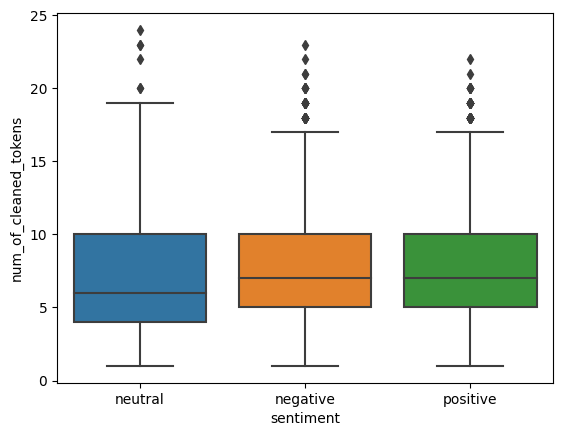

In [86]:
sns.boxplot(data, x='sentiment', y='num_of_cleaned_tokens')
plt.show()

In [87]:
data.groupby(by='sentiment')['num_of_cleaned_tokens'].mean()

sentiment
negative    7.615632
neutral     6.967989
positive    7.676728
Name: num_of_cleaned_tokens, dtype: float64

there isn't a clear relation between the number of words and the sentiment.

### 4.2 Word Frequency Visualization:

#### 4.2.1 Word Colud:

In [88]:
text_before = " ".join(data['text'])

In [89]:
text_after = " ".join([" ".join(tokens) for tokens in data['lemmatized_tokens']])

In [90]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=14)
    plt.show()

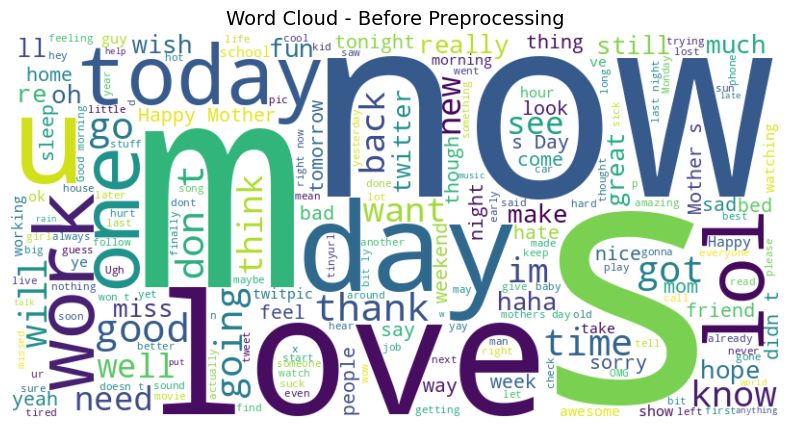

In [91]:
generate_wordcloud(text_before, "Word Cloud - Before Preprocessing")

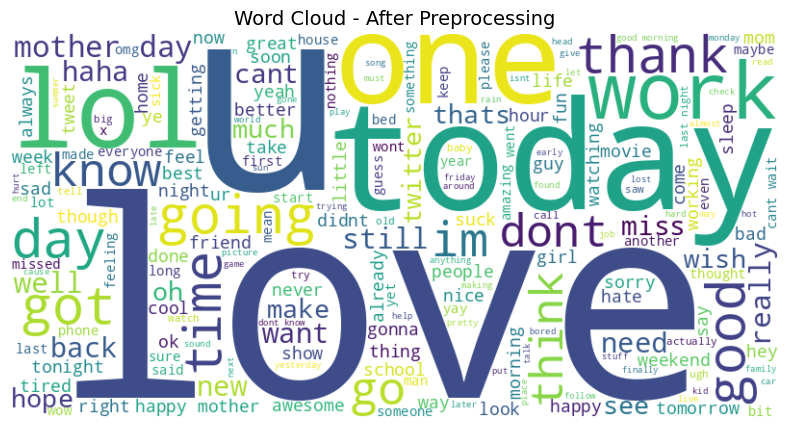

In [92]:
generate_wordcloud(text_after, "Word Cloud - After Preprocessing")

In [93]:
text_after_negative = " ".join([" ".join(tokens) for tokens in data[data['sentiment'] == 'negative']['lemmatized_tokens']])

In [94]:
text_after_positive= " ".join([" ".join(tokens) for tokens in data[data['sentiment'] == 'positive']['lemmatized_tokens']])

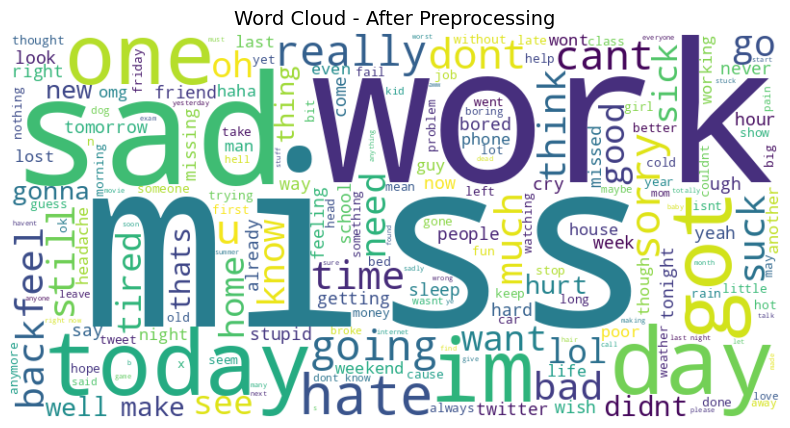

In [95]:
generate_wordcloud(text_after_negative, "Word Cloud - After Preprocessing")

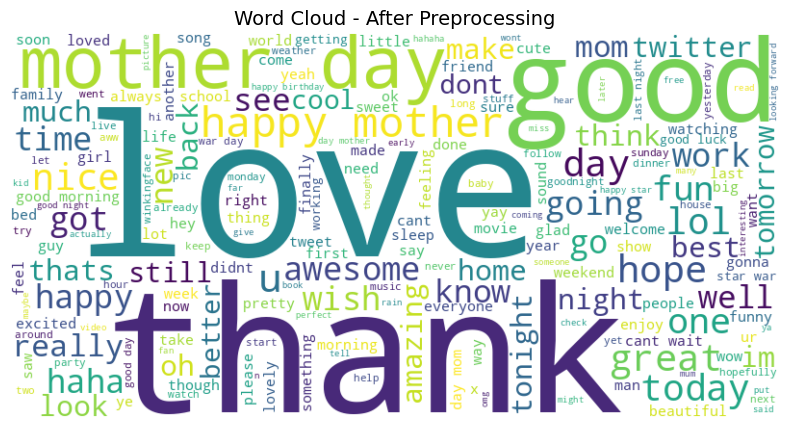

In [96]:
generate_wordcloud(text_after_positive, "Word Cloud - After Preprocessing")

#### 4.2.2 Bar Chart:

In [97]:
def generate_bar_chart(text, title):
    words = text.split()
    word_counts = Counter(words)
    common_words = word_counts.most_common(10)  # Top 10 words
    words, counts = zip(*common_words)

    plt.figure(figsize=(10, 5))
    plt.bar(words, counts, color='skyblue')
    plt.xlabel("Words", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45)
    plt.show()

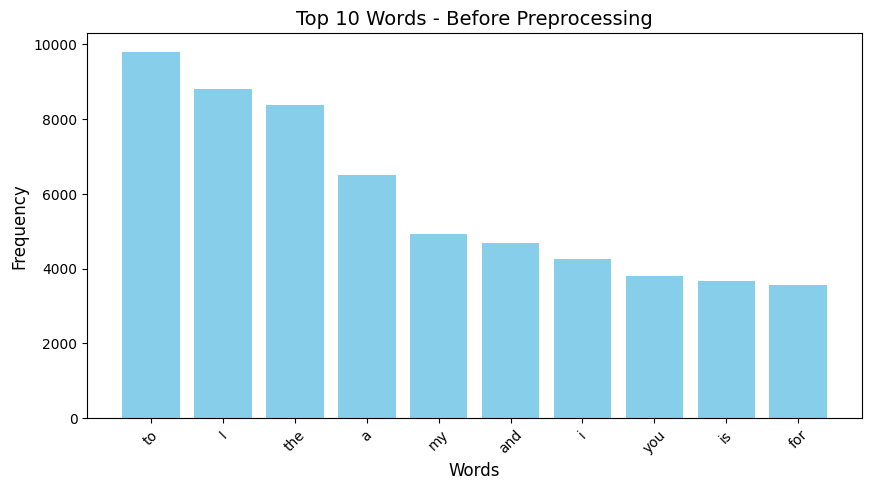

In [98]:
generate_bar_chart(text_before, "Top 10 Words - Before Preprocessing")

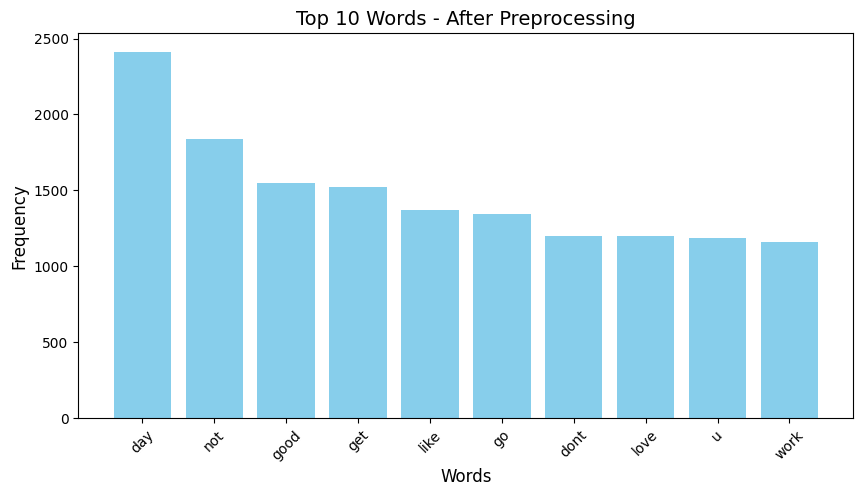

In [99]:
generate_bar_chart(text_after, "Top 10 Words - After Preprocessing")

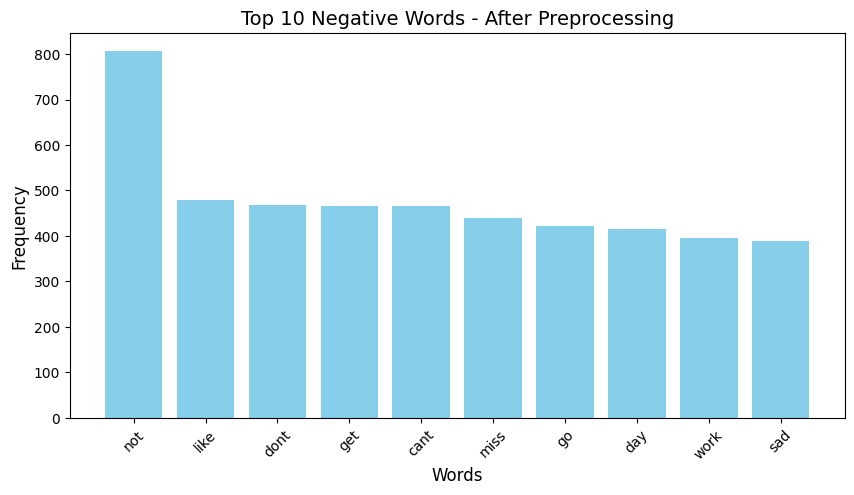

In [100]:
generate_bar_chart(text_after_negative, "Top 10 Negative Words - After Preprocessing")

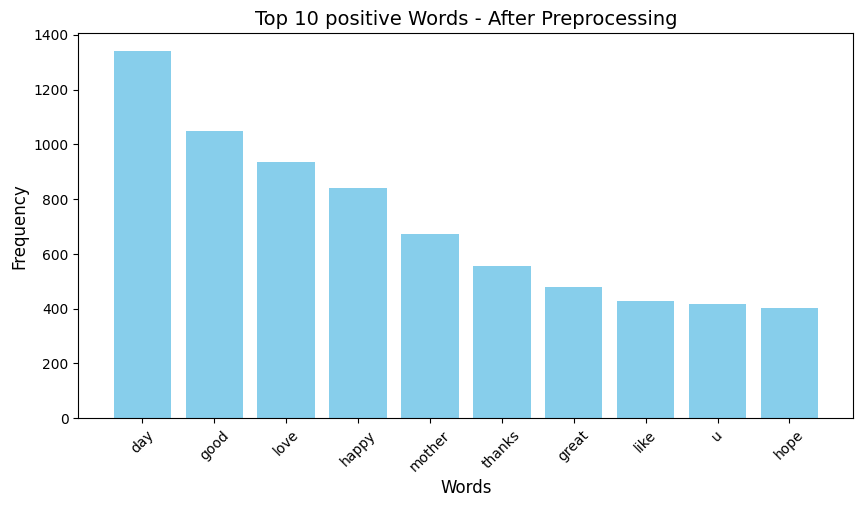

In [101]:
generate_bar_chart(text_after_positive, "Top 10 positive Words - After Preprocessing")

## 5. Lexicon-Based Sentiment Analysis with VADER:

In [102]:
sid = SentimentIntensityAnalyzer()

In [103]:
def vader(text):
    ss = sid.polarity_scores(text)['compound']
    if ss>=0.05:
        return 'positive'
    if ss<=-0.05:
        return 'negative'
    return 'neutral'

In [104]:
vader("I am very happy, It's very cool task!")

'positive'

In [105]:
data['vader_sentiment'] = data['text'].apply(vader)

In [106]:
data['vader_sentiment'].value_counts()

vader_sentiment
positive    13439
neutral      7420
negative     6591
Name: count, dtype: int64

In [107]:
# Ground truth and predictions
y_true = data['sentiment']
y_pred = data['vader_sentiment']

In [108]:
# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

In [109]:
print(f"Accuracy: {accuracy:.3f}")
print(f"Macro Precision: {precision:.3f}")
print(f"Macro Recall: {recall:.3f}")
print(f"Macro F1-Score: {f1:.3f}")

Accuracy: 0.630
Macro Precision: 0.652
Macro Recall: 0.644
Macro F1-Score: 0.627


In [110]:
labels = ["positive", "negative", "neutral"]
cm = confusion_matrix(y_true, y_pred, labels=labels)
print("\nConfusion Matrix:")
print(pd.DataFrame(cm, index=labels, columns=labels))


Confusion Matrix:
          positive  negative  neutral
positive      7463       340      778
negative      1749      4605     1425
neutral       4227      1646     5217


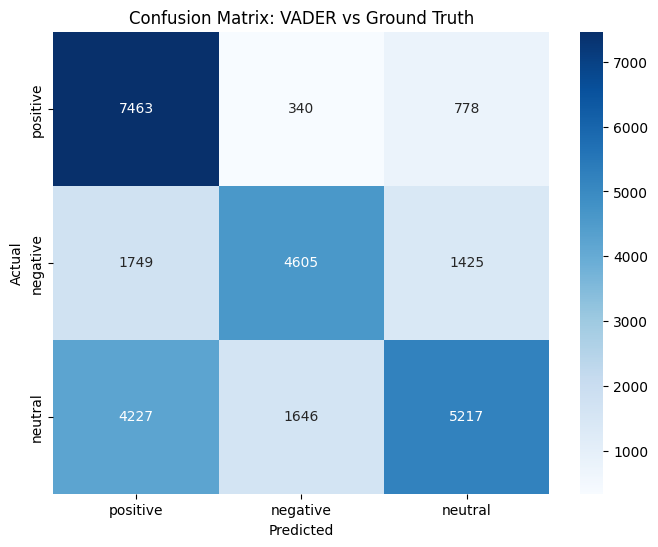

In [111]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix: VADER vs Ground Truth")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [112]:
misclassified = data[data['sentiment'] != data['vader_sentiment']]
# print("\nMisclassified Examples:")
for row in misclassified[['text', 'sentiment', 'vader_sentiment']].values[:10]:
    print(f"Text: {row[0]}")
    print(f"Ground Truth: {row[1]}, VADER Prediction: {row[2]}")
    print("---")

Text:  Sons of ****, why couldn`t they put them on the releases we already bought
Ground Truth: negative, VADER Prediction: neutral
---
Text: http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth
Ground Truth: neutral, VADER Prediction: positive
---
Text:  Journey!? Wow... u just became cooler.  hehe... (is that possible!?)
Ground Truth: positive, VADER Prediction: neutral
---
Text:  as much as i love to be hopeful, i reckon the chances are minimal =P i`m never gonna get my cake and stuff
Ground Truth: neutral, VADER Prediction: positive
---
Text: Uh oh, I am sunburned
Ground Truth: negative, VADER Prediction: neutral
---
Text:  S`ok, trying to plot alternatives as we speak *sigh*
Ground Truth: negative, VADER Prediction: neutral
---
Text:  oh Marly, I`m so sorry!!  I hope you find her soon!! <3 <3
Ground Truth: neutral, VADER Prediction: positive
---
Text: SEe waT I Mean bOuT FoLL0w fRiiDaYs... It`S cALLed LoSe f0LloWeRs FridAy... smH
Ground Trut

## 6. Deep Learning Based Sentiment Analysis:

### 6.1 Data Preparation:

#### 6.1.1 Map sentiments to integers:

In [113]:
sentiment_mapping = {'neutral': 0, 'positive': 1, 'negative': 2}
data['encoded_sentiment'] = data['sentiment'].map(sentiment_mapping)

#### 6.1.2 Train Val Test split:

In [114]:
X_train, X_temp, y_train, y_temp = train_test_split(
    data['lemmatized_tokens'], data['encoded_sentiment'], stratify=data['encoded_sentiment'], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=42)

In [115]:
y_train = to_categorical(y_train, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [116]:
print(len(X_train), len(y_train))
print(len(X_val), len(y_val))
print(len(X_test), len(y_test))

19215 19215
4117 4117
4118 4118


#### 6.1.3 Initialize and fit the tokenizer:

In [117]:
tokenizer.fit_on_texts([word for sequence in X_train for word in sequence])

In [118]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

19759

#### 6.1.4 Convert lemmatized tokens to sequences of integers:

In [119]:
train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)
test_sequences = tokenizer.texts_to_sequences(X_test)

#### 6.1.5 Pad sequences to a fixed length:

In [120]:
max_number_of_tokens = data['num_of_cleaned_tokens'].max()
max_number_of_tokens

24

In [121]:
X_train_padded = pad_sequences(train_sequences, maxlen=max_number_of_tokens, padding='pre', truncating='post')
X_val_padded = pad_sequences(val_sequences, maxlen=max_number_of_tokens, padding='pre', truncating='post')
X_test_padded = pad_sequences(test_sequences, maxlen=max_number_of_tokens, padding='pre', truncating='post')

### 6.2 Define Objective Function for Optuna:

In [122]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

In [123]:
def objective(trial, model_type='LSTM'):
    # Hyperparameter search space
    embedding_dim = trial.suggest_categorical('embedding_dim', [50, 100, 200])
    hidden_units = trial.suggest_categorical('hidden_units', [32, 64, 128])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5, step=0.1)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)

    # Build the model
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=200))

    if model_type == 'RNN':
        model.add(SimpleRNN(hidden_units, dropout=dropout_rate, return_sequences=False))
    elif model_type == 'LSTM':
        model.add(LSTM(hidden_units, dropout=dropout_rate, return_sequences=False))
    elif model_type == 'GRU':
        model.add(GRU(hidden_units, dropout=dropout_rate, return_sequences=False))

    # Output layer for 3-class classification
    model.add(Dense(3, activation='softmax'))  

    # Compile the model
    model.compile(optimizer=Adam(learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train_padded, y_train, validation_data=(X_val_padded, y_val),
                        epochs=5, batch_size=batch_size, verbose=0, callbacks=[early_stopping, lr_scheduler])
    
    # Evaluate performance
    val_accuracy = max(history.history['val_accuracy'])

    return val_accuracy

### 6.3 Run Optuna Optimization:

#### 6.3.1 Study RNN:

In [124]:
study_rnn = optuna.create_study(direction='maximize')
study_rnn.optimize(lambda trial: objective(trial, model_type='RNN'), n_trials=20)

[I 2025-03-04 07:39:48,114] A new study created in memory with name: no-name-d0819f39-9bf1-47c2-bc0a-f13dc223ab50
<ipython-input-123-1f5fc432a6cc>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
[I 2025-03-04 07:39:54,998] Trial 0 finished with value: 0.6808355450630188 and parameters: {'embedding_dim': 50, 'hidden_units': 64, 'dropout_rate': 0.4, 'batch_size': 128, 'learning_rate': 0.0016053136159019836}. Best is trial 0 with value: 0.6808355450630188.
[I 2025-03-04 07:40:02,450] Trial 1 finished with value: 0.6754918694496155 and parameters: {'embedding_dim': 100, 'hidden_units': 32, 'dropout_ra

#### 6.3.2 Study LSTMs:

In [125]:
study_lstm = optuna.create_study(direction='maximize')
study_lstm.optimize(lambda trial: objective(trial, model_type='LSTM'), n_trials=20)

[I 2025-03-04 07:42:59,299] A new study created in memory with name: no-name-7ca15457-7c7d-40ee-9468-9e33c7871479
<ipython-input-123-1f5fc432a6cc>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2025-03-04 07:43:16,263] Trial 0 finished with value: 0.7005100846290588 and parameters: {'embedding_dim': 200, 'hidden_units': 32, 'dropout_rate': 0.2, 'batch_size': 32, 'learning_rate': 0.0006243354652134284}. Best is trial 0 with value: 0.7005100846290588.
[I 2025-03-04 07:43:21,101] Trial 1 finished with value: 0.6924945116043091 and parameters: {'embedding_dim': 200, 'hidden_units': 32, 'dropout_rate': 0.30000000000000004, 'batch_size': 128, 'learning_rate': 0.00026297137744621136}. Best is trial 0 with value: 0.7005100846290588.
[I 2025-03-04 07:43:27,815] T

#### 6.3.3 Study GRU:

In [126]:
study_gru = optuna.create_study(direction='maximize')
study_gru.optimize(lambda trial: objective(trial, model_type='GRU'), n_trials=20)

[I 2025-03-04 07:45:15,228] A new study created in memory with name: no-name-8bd685d1-c36e-4f68-a124-dcd2250aa308
<ipython-input-123-1f5fc432a6cc>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2025-03-04 07:45:20,263] Trial 0 finished with value: 0.6961379647254944 and parameters: {'embedding_dim': 200, 'hidden_units': 128, 'dropout_rate': 0.2, 'batch_size': 128, 'learning_rate': 0.0014903203645491507}. Best is trial 0 with value: 0.6961379647254944.
[I 2025-03-04 07:45:26,693] Trial 1 finished with value: 0.6776779294013977 and parameters: {'embedding_dim': 100, 'hidden_units': 64, 'dropout_rate': 0.30000000000000004, 'batch_size': 64, 'learning_rate': 0.0001346711165435978}. Best is trial 0 with value: 0.6961379647254944.
[I 2025-03-04 07:45:31,038] T

In [127]:
print("Best hyperparameters for LSTM:", study_lstm.best_params)
print("Best hyperparameters for RNN:", study_rnn.best_params)
print("Best hyperparameters for GRU:", study_gru.best_params)

Best hyperparameters for LSTM: {'embedding_dim': 50, 'hidden_units': 32, 'dropout_rate': 0.4, 'batch_size': 128, 'learning_rate': 0.007771988185248378}
Best hyperparameters for RNN: {'embedding_dim': 50, 'hidden_units': 32, 'dropout_rate': 0.2, 'batch_size': 64, 'learning_rate': 0.003571394723241139}
Best hyperparameters for GRU: {'embedding_dim': 50, 'hidden_units': 32, 'dropout_rate': 0.30000000000000004, 'batch_size': 32, 'learning_rate': 0.006023416719430831}


### 6.4 Train the Models with the best hyperparameters:

#### 6.4.1 Train RNN:

In [128]:
best_params = study_rnn.best_params

rnn_final_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=best_params['embedding_dim'], input_length=200),
    SimpleRNN(best_params['hidden_units'], dropout=best_params['dropout_rate'], return_sequences=False),
    Dense(3, activation='softmax')
])

rnn_final_model.compile(optimizer=Adam(best_params['learning_rate']), loss='categorical_crossentropy',
                        metrics=['accuracy'])

rnn_history = rnn_final_model.fit(X_train_padded, y_train, validation_data=(X_val_padded, y_val),
                epochs=10, batch_size=best_params['batch_size'], callbacks=[early_stopping, lr_scheduler])


Epoch 1/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5127 - loss: 0.9543 - val_accuracy: 0.6663 - val_loss: 0.7520 - learning_rate: 0.0036
Epoch 2/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8016 - loss: 0.5041 - val_accuracy: 0.6582 - val_loss: 0.8632 - learning_rate: 0.0036
Epoch 3/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9185 - loss: 0.2364 - val_accuracy: 0.6405 - val_loss: 1.0686 - learning_rate: 0.0036


#### 6.4.2 Train LSTMs:

In [129]:
best_params = study_lstm.best_params

lstm_final_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=best_params['embedding_dim'], input_length=200),
    LSTM(best_params['hidden_units'], dropout=best_params['dropout_rate'], return_sequences=False),
    Dense(3, activation='softmax')
])

lstm_final_model.compile(optimizer=Adam(best_params['learning_rate']), loss='categorical_crossentropy',
                        metrics=['accuracy'])

lstm_history = lstm_final_model.fit(X_train_padded, y_train, validation_data=(X_val_padded, y_val),
                epochs=10, batch_size=best_params['batch_size'], callbacks=[early_stopping, lr_scheduler])


Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5576 - loss: 0.9088 - val_accuracy: 0.7093 - val_loss: 0.6939 - learning_rate: 0.0078
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7878 - loss: 0.5219 - val_accuracy: 0.6981 - val_loss: 0.7248 - learning_rate: 0.0078
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8730 - loss: 0.3421 - val_accuracy: 0.6913 - val_loss: 0.8133 - learning_rate: 0.0078


#### 6.4.3 Train GRU:

In [130]:
best_params = study_gru.best_params

gru_final_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=best_params['embedding_dim'], input_length=200),
    GRU(best_params['hidden_units'], dropout=best_params['dropout_rate'], return_sequences=False),
    Dense(3, activation='softmax')
])

gru_final_model.compile(optimizer=Adam(best_params['learning_rate']), loss='categorical_crossentropy',
                        metrics=['accuracy'])

gru_history = gru_final_model.fit(X_train_padded, y_train, validation_data=(X_val_padded, y_val),
                epochs=10, batch_size=best_params['batch_size'], callbacks=[early_stopping, lr_scheduler])


Epoch 1/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5946 - loss: 0.8608 - val_accuracy: 0.7161 - val_loss: 0.6931 - learning_rate: 0.0060
Epoch 2/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8134 - loss: 0.4750 - val_accuracy: 0.6986 - val_loss: 0.7563 - learning_rate: 0.0060
Epoch 3/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9029 - loss: 0.2740 - val_accuracy: 0.6855 - val_loss: 0.8878 - learning_rate: 0.0060


#### 6.4.4 Plot Training & Validation Loss/Accuracy:

In [131]:
def plot_training_curves(history, model_name):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Curve - {model_name}')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve - {model_name}')
    plt.legend()

    plt.show()


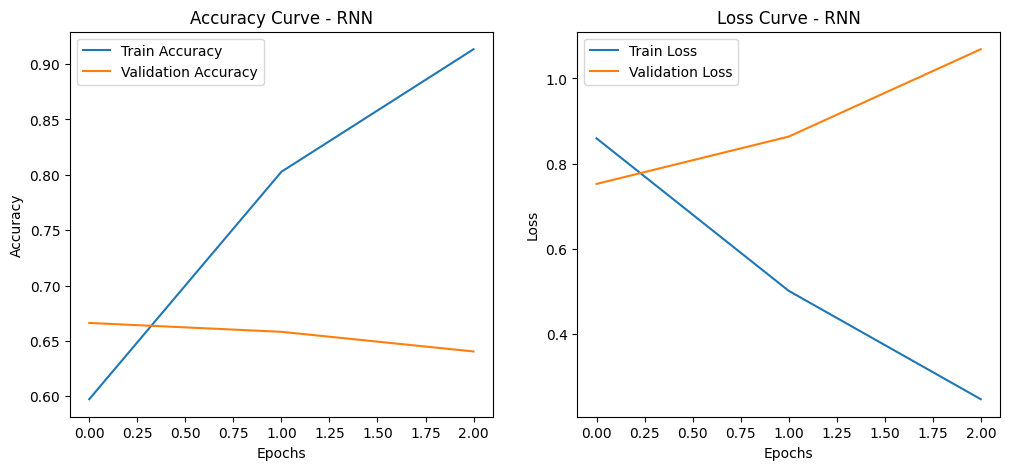

In [132]:
plot_training_curves(rnn_history, "RNN")

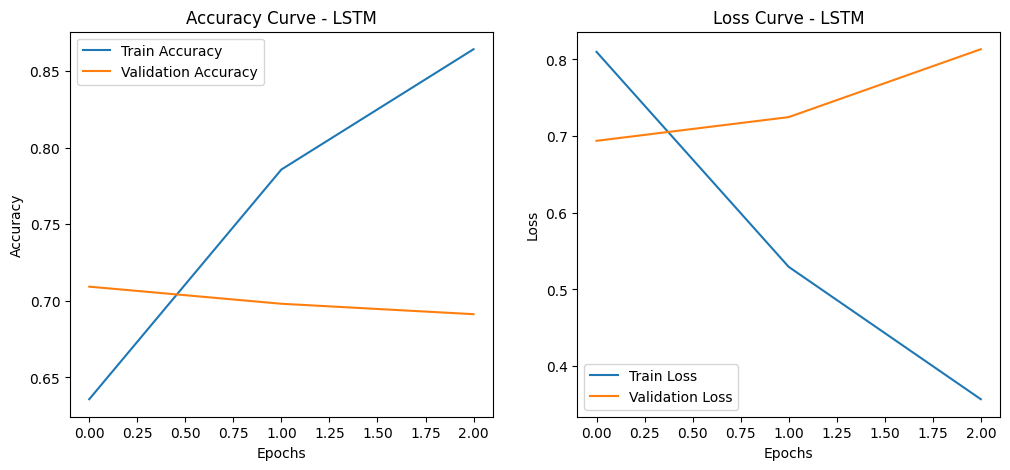

In [133]:
plot_training_curves(lstm_history, "LSTM")

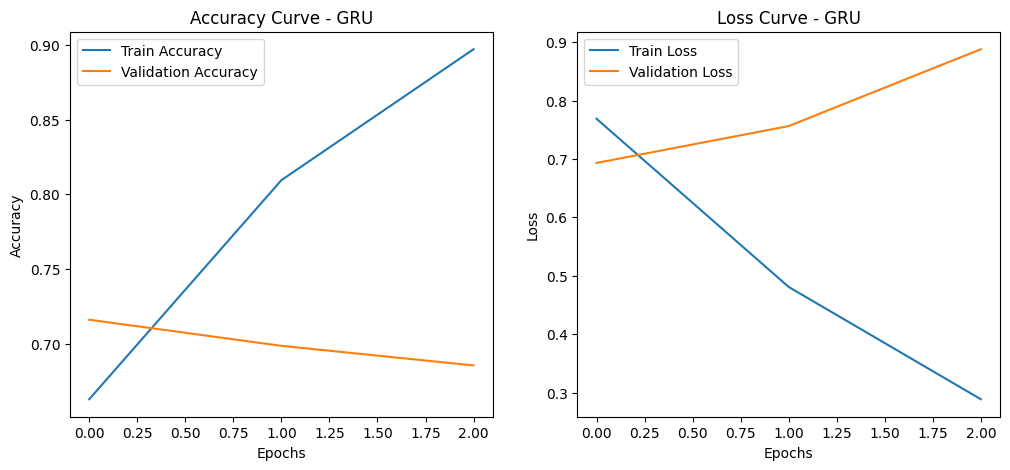

In [134]:
plot_training_curves(gru_history, "GRU")

### 6.5 Evalute Models:

In [135]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred_prob = model.predict(X_test_padded)
    y_pred = y_pred_prob.argmax(axis=1)
    y_true = y_test.argmax(axis=1)

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive'])
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"Evaluation for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    return accuracy, report


129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Evaluation for RNN:
Accuracy: 0.6717
Classification Report:
              precision    recall  f1-score   support

    Negative       0.67      0.57      0.62      1664
     Neutral       0.74      0.74      0.74      1287
    Positive       0.60      0.74      0.67      1167

    accuracy                           0.67      4118
   macro avg       0.67      0.68      0.68      4118
weighted avg       0.68      0.67      0.67      4118



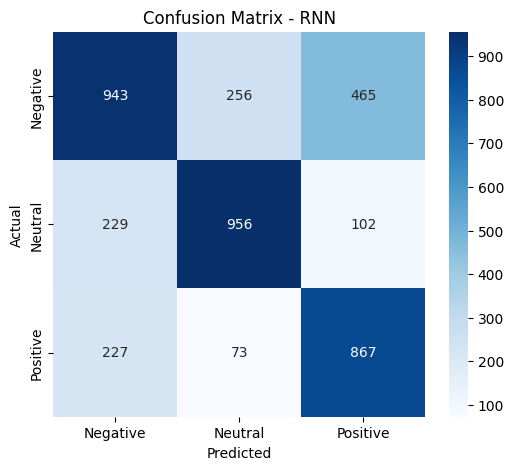

In [136]:
rnn_acc, rnn_report = evaluate_model(rnn_final_model, X_test, y_test, "RNN")

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Evaluation for LSTM:
Accuracy: 0.7006
Classification Report:
              precision    recall  f1-score   support

    Negative       0.63      0.76      0.69      1664
     Neutral       0.79      0.72      0.75      1287
    Positive       0.73      0.59      0.65      1167

    accuracy                           0.70      4118
   macro avg       0.72      0.69      0.70      4118
weighted avg       0.71      0.70      0.70      4118



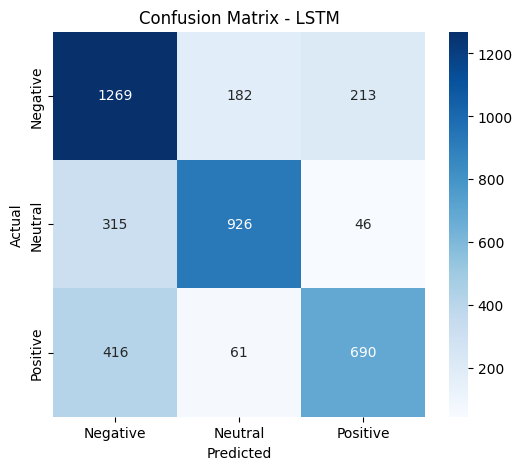

In [137]:
lstm_acc, lstm_report = evaluate_model(lstm_final_model, X_test, y_test, "LSTM")

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Evaluation for GRU:
Accuracy: 0.7023
Classification Report:
              precision    recall  f1-score   support

    Negative       0.62      0.78      0.70      1664
     Neutral       0.78      0.75      0.76      1287
    Positive       0.79      0.53      0.64      1167

    accuracy                           0.70      4118
   macro avg       0.73      0.69      0.70      4118
weighted avg       0.72      0.70      0.70      4118



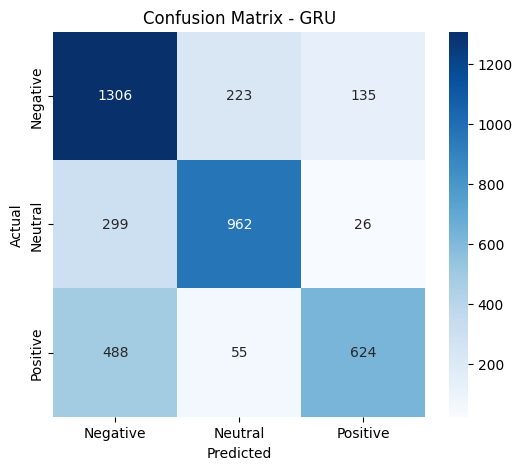

In [138]:
gru_acc, gru_report = evaluate_model(gru_final_model, X_test, y_test, "GRU")

### 6.6 Compare Model Performance:

In [139]:
model_comparison = pd.DataFrame({
    "Model": ["Vader", "RNN", "LSTM", "GRU"],
    "Test Accuracy": [accuracy, rnn_acc, lstm_acc, gru_acc],
})

print("Performance Comparison Table:")
print(model_comparison)

Performance Comparison Table:
   Model  Test Accuracy
0  Vader       0.629690
1    RNN       0.671685
2   LSTM       0.700583
3    GRU       0.702283
